# Mushroom Identifier Classification Model

In this repo I will use classification models to identify if mushrooms are edible or poisonous. The data is an old UCI dataset from about 30 years ago - but still in good shape today and can be found on Kaggle!

This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one.

# Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
import datetime as dt

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                    GridSearchCV)

from sklearn.metrics import (accuracy_score, 
                            f1_score, 
                            confusion_matrix, 
                            classification_report,
                            confusion_matrix)

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import SGDClassifier

import xgboost as xgb

# Data

In [2]:
# Load the data
df = pd.read_csv("mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
# The data is all categorical!

# EDA

In [4]:
# Do some initial research
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [5]:
# Get a look at the statistics
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [6]:
# No missing values
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [7]:
# Check for duplicates
duplicates = df[df.duplicated()]
print(len(duplicates))

0


In [8]:
# Number of edible and poisonous mushrooms 
df['class'].value_counts()

e    4208
p    3916
Name: class, dtype: int64

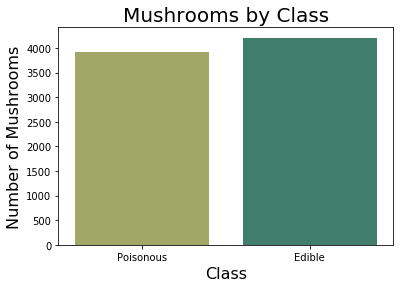

In [9]:
# Look at the two classes - edible and poisonous
sns.countplot(data=df, x = 'class', palette = 'gist_earth_r')
plt.title('Mushrooms by Class', fontsize = 20)
plt.ylabel('Number of Mushrooms', fontsize=16)
plt.xlabel('Class', fontsize=16)
plt.xticks(np.arange(0, 2), ['Poisonous', 'Edible'])
plt.show()

In [10]:
# From documentation - Different types of mushroom colors
# cap-color = [brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y]
df['cap-color'].value_counts()

n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: cap-color, dtype: int64

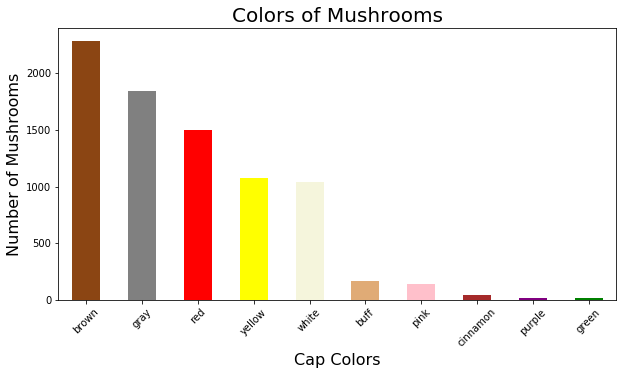

In [11]:
# Colors of mushrooms on a color-coded bar graph
labels = ['brown','gray','red','yellow','white','buff','pink','cinnamon','purple','green']
colors = list(['#8B4513','gray','red','yellow','beige','#E0AB76','pink','brown','purple','green'])

df['cap-color'].value_counts().plot(kind='bar', color = colors, figsize=(10,5))
plt.title('Colors of Mushrooms', fontsize = 20)
plt.ylabel('Number of Mushrooms', fontsize=16)
plt.xlabel('Cap Colors', fontsize=16)
plt.xticks(np.arange(0, 10), labels, rotation = 45)
plt.show()

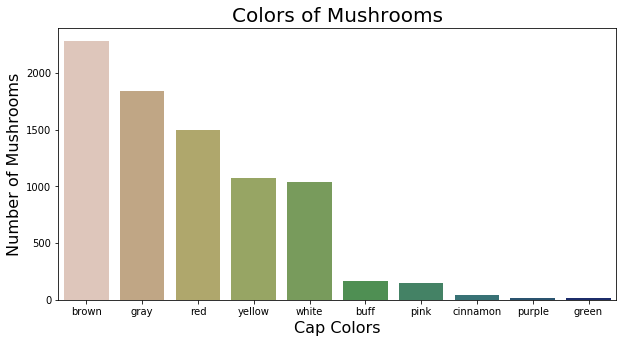

In [12]:
# I tried to match mushroom colors with Seaborn but couldn't get the colors correct.
color_labels = ['brown','gray','red','yellow','white','buff','pink','cinnamon','purple','green']

plt.figure(figsize=(10,5))
cap_color = df['cap-color'].value_counts()
sns.barplot(cap_color.index, cap_color.values, palette = 'gist_earth_r')
plt.title('Colors of Mushrooms', fontsize = 20)
plt.ylabel('Number of Mushrooms', fontsize=16)
plt.xlabel('Cap Colors', fontsize=16)
plt.xticks(np.arange(0, 10), color_labels)
plt.show()

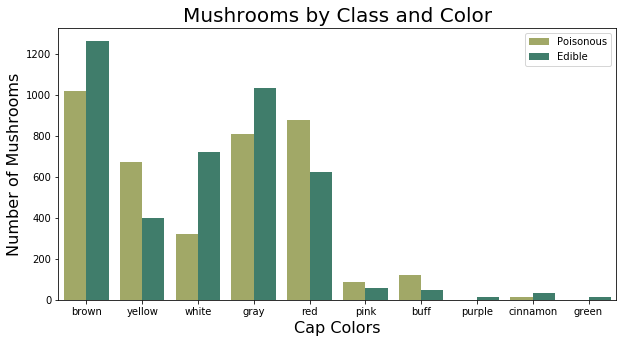

In [13]:
# This is another visual with an earthy palatte color.
color_label_again = ['brown','yellow','white','gray','red','pink','buff','purple','cinnamon','green']
plt.figure(figsize=(10,5))
sns.countplot(data=df, x = 'cap-color', hue = 'class', palette = 'gist_earth_r')
plt.title('Mushrooms by Class and Color', fontsize = 20)
plt.ylabel('Number of Mushrooms', fontsize=16)
plt.xlabel('Cap Colors', fontsize=16)
plt.xticks(np.arange(0, 10), color_label_again)
plt.legend(loc='upper right', labels = ['Poisonous', 'Edible'])
plt.show()

In [14]:
# From documention - How do mushrooms smell?
# odor = [almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s]
df['odor'].value_counts()

n    3528
f    2160
y     576
s     576
a     400
l     400
p     256
c     192
m      36
Name: odor, dtype: int64

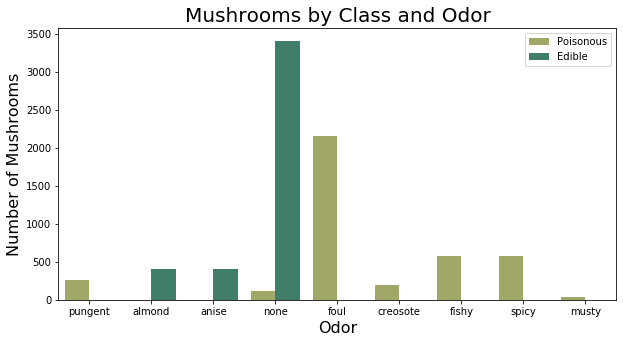

In [15]:
# Visualize mushrooms by odor
odor_labels = ['pungent','almond','anise','none','foul','creosote','fishy','spicy','musty']
plt.figure(figsize=(10,5))
sns.countplot(data=df, x = 'odor', hue = 'class', palette = 'gist_earth_r')
plt.title('Mushrooms by Class and Odor', fontsize = 20)
plt.ylabel('Number of Mushrooms', fontsize=16)
plt.xlabel('Odor', fontsize=16)
plt.xticks(np.arange(0, 9), odor_labels)
plt.legend(loc='upper right', labels = ['Poisonous', 'Edible'])
plt.show()

In [16]:
# From documention - where do you find mushrooms?
# habitat = [grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d]
df['habitat'].value_counts()

d    3148
g    2148
p    1144
l     832
u     368
m     292
w     192
Name: habitat, dtype: int64

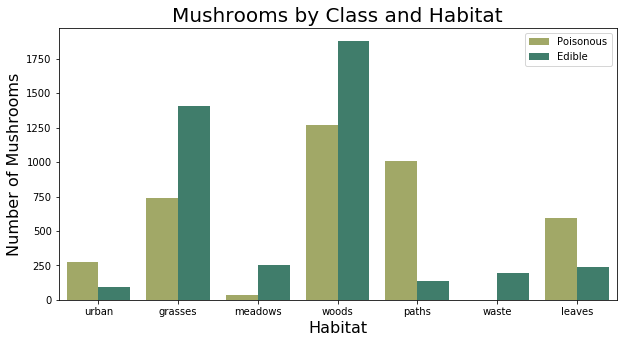

In [17]:
# Take a look at the different habitat of mushrooms
habitat_labels = ['urban', 'grasses', 'meadows','woods','paths','waste','leaves']
plt.figure(figsize=(10,5))
sns.countplot(data=df, x = 'habitat', hue = 'class', palette = 'gist_earth_r')
plt.title('Mushrooms by Class and Habitat', fontsize = 20)
plt.ylabel('Number of Mushrooms', fontsize=16)
plt.xlabel('Habitat', fontsize=16)
plt.xticks(np.arange(0, 7), habitat_labels)
plt.legend(loc='upper right', labels = ['Poisonous', 'Edible'])
plt.show()

In [18]:
# From Documentation - What does population mean?
# population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
df['population'].value_counts()

v    4040
y    1712
s    1248
n     400
a     384
c     340
Name: population, dtype: int64

# Converting Categorical Data

In [237]:
# Check out the dataframe again
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [210]:
# Independent target variable
y = df['class']
y

0       p
1       e
2       e
3       p
4       e
       ..
8119    e
8120    e
8121    e
8122    p
8123    e
Name: class, Length: 8124, dtype: object

In [214]:
# Replace target values 
y = y.replace({'e' : 1, 'p' : 0 })
y

0       0
1       1
2       1
3       0
4       1
       ..
8119    1
8120    1
8121    1
8122    0
8123    1
Name: class, Length: 8124, dtype: int64

In [135]:
# Drop target and set the dependent values variables 
X = df.drop('class', axis=1)
X

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,s,o,o,p,o,o,p,b,c,l
8120,x,s,n,f,n,a,c,b,y,e,...,s,o,o,p,n,o,p,b,v,l
8121,f,s,n,f,n,a,c,b,n,e,...,s,o,o,p,o,o,p,b,c,l
8122,k,y,n,f,y,f,c,n,b,t,...,k,w,w,p,w,o,e,w,v,l


In [136]:
# Use One Hot Encoding to change all categorical data to 0 and 1's
X = pd.concat([pd.get_dummies(X[col], drop_first = True) for col in X], axis=1, keys=X.columns)
X.head()

cap-shape             cap-surface       cap-color     ... population        \
          c  f  k  s  x           g  s  y         c  e  ...          n  s  v   
0         0  0  0  0  1           0  1  0         0  0  ...          0  1  0   
1         0  0  0  0  1           0  1  0         0  0  ...          1  0  0   
2         0  0  0  0  0           0  1  0         0  0  ...          1  0  0   
3         0  0  0  0  1           0  0  1         0  0  ...          0  1  0   
4         0  0  0  0  1           0  1  0         0  0  ...          0  0  0   

     habitat                 
   y       g  l  m  p  u  w  
0  0       0  0  0  0  1  0  
1  0       1  0  0  0  0  0  
2  0       0  0  1  0  0  0  
3  0       0  0  0  0  1  0  
4  0       1  0  0  0  0  0  

[5 rows x 95 columns]

When researching this project I noticed that many people used the simple Label_Encoder() method to convert the categorical data. While using One Hot Encoding drastically increases the size of the dataset I believe that since there is no hierarchical difference within each column of variables it doesn't make sense to use the Label Encoder.

# Test/Train Split

In [139]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# PCA - Principal component analysis

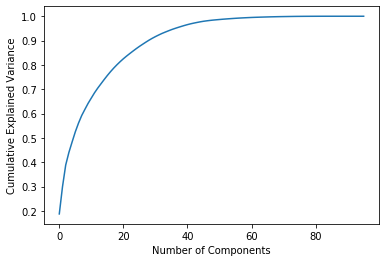

In [240]:
# How many components?
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

According to the PCA curve above, choosing around 25 - 30 features would give me a 90% variance. But when I entered that many n_components my models were still over-fitting. I re-ran the PCA Cumulative Explained Variance function on the data before one-hot encoding and found that a better fit would be to choose n_components = 9.

In [215]:
# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 9)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Since my models were over-fitting the data with all 95 features (from the one-hot encoding) I needed to figure out a way to reduce the columns. I tried using feature selection but decided that PCA was easier, though certainly less transparent. 

# Models

In [216]:
# Create a list to store the results of each model
valscore = []

# This is a list of the models I plan to run:
models = ['Logistic Regression Model',
          'Random Forest Model',
          'XGBoost Model',
          'KNN Model',
          'Support Vector Model',
          'Stochastic Decent Model']

## Logistic Regression Model

In [217]:
# Log model
log_clf = LogisticRegression(random_state=123)
log_model = log_clf.fit(X_train, y_train)

log_training_preds = log_clf.predict(X_train)
log_training_accuracy = accuracy_score(y_train, log_training_preds)

log_val_preds = log_clf.predict(X_test)
log_val_accuracy = accuracy_score(y_test, log_val_preds)
valscore.append(log_val_accuracy)

print("Log Training Accuracy: {:.4}%".format(log_training_accuracy * 100))
print("Log Validation Accuracy: {:.4}%".format(log_val_accuracy * 100))

Log Training Accuracy: 94.93%
Log Validation Accuracy: 94.78%


In [218]:
# Classification report, precision and recall
print(classification_report(y_test, log_val_preds))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1069
           1       0.96      0.93      0.94       962

    accuracy                           0.95      2031
   macro avg       0.95      0.95      0.95      2031
weighted avg       0.95      0.95      0.95      2031



In [219]:
# Confusion matrix 
log_matrix = confusion_matrix(y_test, log_val_preds)
print('Confusion Matrix:\n', log_matrix)

Confusion Matrix:
 [[1028   41]
 [  65  897]]


## Random Forest Model

In [220]:
# Forest Model
forest_clf = RandomForestClassifier()
forest_model = forest_clf.fit(X_train, y_train)

forest_training_preds = forest_clf.predict(X_train)
forest_training_accuracy = accuracy_score(y_train, forest_training_preds)

forest_val_preds = forest_clf.predict(X_test) # y_hat
forest_val_accuracy = accuracy_score(y_test, forest_val_preds)
valscore.append(forest_val_accuracy)

print("Forest Training Accuracy: {:.4}%".format(forest_training_accuracy * 100))
print("Forest Validation accuracy: {:.4}%".format(forest_val_accuracy * 100))

Forest Training Accuracy: 100.0%
Forest Validation accuracy: 99.95%


In [221]:
# Classification report
print(classification_report(y_test, forest_val_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1069
           1       1.00      1.00      1.00       962

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



In [222]:
# Confusion matrix 
forest_matrix = confusion_matrix(y_test, forest_val_preds)
print('Confusion Matrix:\n', forest_matrix)

Confusion Matrix:
 [[1069    0]
 [   1  961]]


## XGBoost Model

In [223]:
# XGB classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

xgb_training_preds = xgb_clf.predict(X_train)
xgb_training_accuracy = accuracy_score(y_train, xgb_training_preds)

xgb_val_preds = xgb_clf.predict(X_test)
xgb_val_accuracy = accuracy_score(y_test, xgb_val_preds)
valscore.append(xgb_val_accuracy)

print("XGB Training Accuracy: {:.4}%".format(xgb_training_accuracy * 100))
print("XGB Validation accuracy: {:.4}%".format(xgb_val_accuracy * 100))

XGB Training Accuracy: 99.57%
XGB Validation accuracy: 99.51%


In [224]:
# XGB classification report
print(classification_report(y_test, xgb_val_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1069
           1       1.00      0.99      0.99       962

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



In [225]:
# Regular confusion matrix
xgb_matrix = confusion_matrix(y_test, xgb_val_preds)
print('Confusion Matrix:\n', xgb_matrix)

Confusion Matrix:
 [[1065    4]
 [   6  956]]


## KNN Model

In [226]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

knn_training_preds = knn_clf.predict(X_train)
knn_training_accuracy = accuracy_score(y_train, knn_training_preds)

knn_val_preds = knn_clf.predict(X_test)
knn_val_accuracy = accuracy_score(y_test, knn_val_preds)
valscore.append(knn_val_accuracy)

print("KNN Training Accuracy: {:.4}%".format(knn_training_accuracy * 100))
print("KNN Validation accuracy: {:.4}%".format(knn_val_accuracy * 100))

KNN Training Accuracy: 99.95%
KNN Validation accuracy: 99.8%


In [227]:
# KNN classification report
print(classification_report(y_test, knn_val_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1069
           1       1.00      1.00      1.00       962

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



In [228]:
# Regular confusion matrix
knn_matrix = confusion_matrix(y_test, knn_val_preds)
print('Confusion Matrix:\n', knn_matrix)

Confusion Matrix:
 [[1065    4]
 [   0  962]]


## Support Vector Model - SVC

In [229]:
svc_clf = SVC()
svc_clf.fit(X_train, y_train)

svc_training_preds = svc_clf.predict(X_train)
svc_training_accuracy = accuracy_score(y_train, svc_training_preds)

svc_val_preds = svc_clf.predict(X_test)
svc_val_accuracy = accuracy_score(y_test, svc_val_preds)
valscore.append(svc_val_accuracy)

print("SVC Training Accuracy: {:.4}%".format(svc_training_accuracy * 100))
print("SVC Validation accuracy: {:.4}%".format(svc_val_accuracy * 100))

SVC Training Accuracy: 99.89%
SVC Validation accuracy: 99.66%


In [230]:
# SVC classification report
print(classification_report(y_test, svc_val_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1069
           1       1.00      1.00      1.00       962

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



In [231]:
# Regular confusion matrix
svc_matrix = confusion_matrix(y_test, svc_val_preds)
print('Confusion Matrix:\n', svc_matrix)

Confusion Matrix:
 [[1066    3]
 [   4  958]]


## Stochastic Gradient Decent Model

In [232]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

sgd_training_preds = sgd_clf.predict(X_train)
sgd_training_accuracy = accuracy_score(y_train, svc_training_preds)

sgd_val_preds = sgd_clf.predict(X_test)
sgd_val_accuracy = accuracy_score(y_test, sgd_val_preds)
valscore.append(sgd_val_accuracy)

print("Stochastic GD Training Accuracy: {:.4}%".format(sgd_training_accuracy * 100))
print("Stochastic GD Validation accuracy: {:.4}%".format(sgd_val_accuracy * 100))

Stochastic GD Training Accuracy: 99.89%
Stochastic GD Validation accuracy: 94.04%


In [233]:
# Stochastic classification report
print(classification_report(y_test, sgd_val_preds))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1069
           1       0.95      0.92      0.94       962

    accuracy                           0.94      2031
   macro avg       0.94      0.94      0.94      2031
weighted avg       0.94      0.94      0.94      2031



In [234]:
# Regular confusion matrix
sgd_matrix = confusion_matrix(y_test, sgd_val_preds)
print('Confusion Matrix:\n', sgd_matrix)

Confusion Matrix:
 [[1025   44]
 [  77  885]]


# Summary

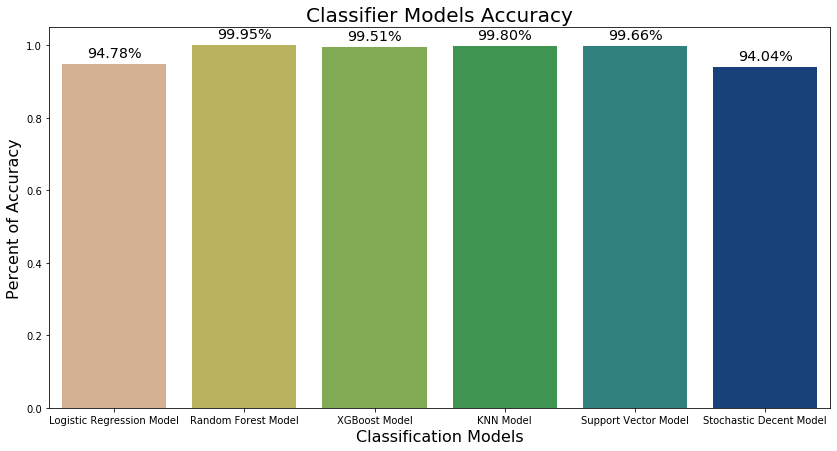

In [235]:
# Visualising the accuracy score of each classification model
plt.figure(figsize=(14,7))
ax = sns.barplot(x=models, y=valscore, palette = "gist_earth_r", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 16)
plt.ylabel("Percent of Accuracy", fontsize = 16)
plt.title("Classifier Models Accuracy", fontsize = 20)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

Originally all of my models were over-fitting and getting close to 100% accuracy. I tried using PCA components to reduce the number of features but still found that the models needed less columns. You can see from the bar graph above that the Random Forest Model did the best after one-hot encoding the categorical data, though many of the models were close.

This has been an interesting data set with a few aspects that have really challenged me - in particular the purely numerous categorical columns and the feature selection.  I looked at a few examples of this Kaggle and noticed many people used Label Encoding verses One_Hot Encoding. Plus, the PCA verses Feature Selection both added a lot of time to my project and I needed to review much data science and statistical information.

# Future Work

I would love to go find some mushrooms around my house and categorize them in order to determine if they are poisonous or not! For now I just need to work on fixing my models. I want to do move work with feature selection - especially using the mushroom identifiers that I am most familiar with (such as size, cap-color, and location). Perhaps my model would fair better (though with lower accuracy) if I took out more of the the features.